In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchsummary as summary

In [2]:
from torchvision.models import vgg16, VGG16_Weights

In [3]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transform_vgg = VGG16_Weights.DEFAULT.transforms()
# Download the dataset
trainset_vgg = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_vgg)
testset_vgg = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_vgg)
testloader_vgg = torch.utils.data.DataLoader(testset_vgg, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Split the training dataset into training and validation
size_validset_vgg = 10000
size_trainset_vgg = len(trainset_vgg)-size_validset_vgg
train_set_vgg, valid_set_vgg = random_split(trainset_vgg, [size_trainset_vgg, size_validset_vgg])

trainloader_vgg = torch.utils.data.DataLoader(train_set_vgg, batch_size=32, shuffle=True)
validloader_vgg = torch.utils.data.DataLoader(valid_set_vgg, batch_size=32, shuffle=True)
# now we have training validation and testing 

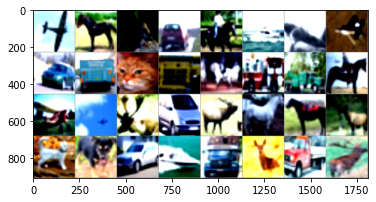

plane horse  bird   car


In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_vgg)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
def train(epochs, model, optimizer):
    train_loss_ls = []
    train_accuracy_ls = []
    val_loss_ls = []
    val_accuracy_ls = []
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        '''
        This is the training section
        '''
        training_loss = 0
        training_correct = 0
        model.train() # the model is in training mode, will consider evething like batch normalization and dropout
        
        for i, data in enumerate(trainloader_vgg, 0): # each data is one batch
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = outputs.argmax(1)# index of max probability out of 10 classes

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item()
            training_correct += (predicted == labels).sum().item()

        '''
        This is the validation section
        '''
        val_loss = 0
        val_correct = 0
#         val_total = 0
        model.eval()
        with torch.no_grad(): # do not perform any calculation  
            for data in validloader_vgg:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.argmax(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
#                 val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

#         print('Val Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        training_loss = training_loss/(len(trainloader_vgg)) # this is consider as batch
        train_acc = (training_correct / len(trainloader_vgg.dataset)) # this consider as all simple
        val_loss = val_loss / len(validloader_vgg)
        val_acc = (val_correct/len(validloader_vgg.dataset))
        
        # save the loss and accuracy in the list
        train_loss_ls.append(training_loss)
        train_accuracy_ls.append(train_acc)
        val_loss_ls.append(val_loss)
        val_accuracy_ls.append(val_acc)
        print("epoch",epoch)
        print("train_accuracy: ",train_acc,"val_accuracy: ",val_acc,"train_loss: ",training_loss, "val_loss:", val_loss)


    print('Finished Training')
    return (train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls)

In [9]:
# create a function to plot the graph of accuracy and loss 
def plot_graph(train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls,epoch):
    # plotting the baseline model
    plt.plot(np.arange(epoch),train_accuracy_ls ,label ="Train accuracy")
    plt.plot(np.arange(epoch),val_accuracy_ls ,label ="Val accuracy")
    plt.plot(np.arange(epoch),train_loss_ls ,label = "train loss")
    plt.plot(np.arange(epoch),val_loss_ls ,label = "val loss")
    plt.title("Training accuracy and loss")
    plt.xlabel("Number of epoch")
    plt.legend()
    plt.show()

In [10]:
vgg_model_one = vgg16(weights = VGG16_Weights.DEFAULT, progress=True)
vgg_model_one.fc = nn.Linear(4096,10)
print(vgg_model_one)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# vgg16, SGD, 0.001, 5 epochs
optimizer_vgg_one = optim.SGD(vgg_model_one.parameters(), lr=0.001, momentum=0.9)
results_vgg_one = train(5, vgg_model_one, optimizer_vgg_one)

epoch 0
train_accuracy:  0.691625 val_accuracy:  0.8456 train_loss:  0.9247128911852837 val_loss: 0.4415183400098508
epoch 1
train_accuracy:  0.869475 val_accuracy:  0.8915 train_loss:  0.3795463908493519 val_loss: 0.3151102795625647
epoch 2
train_accuracy:  0.917775 val_accuracy:  0.9079 train_loss:  0.24229598772227764 val_loss: 0.2748106056318496
epoch 3
train_accuracy:  0.9432 val_accuracy:  0.9049 train_loss:  0.16507593032978476 val_loss: 0.30572404724935565
epoch 4
train_accuracy:  0.960175 val_accuracy:  0.9072 train_loss:  0.11423738159528002 val_loss: 0.30085680939066717
Finished Training


In [12]:
# vgg16, SGD, 0.0001, 5 epochs, momentum = 0.9
vgg_model_two = vgg16(weights = VGG16_Weights.DEFAULT, progress=True)
vgg_model_two.fc = nn.Linear(4096,10)
optimizer_vgg_two = optim.SGD(vgg_model_two.parameters(), lr=0.0001, momentum= 0.9)
results_vgg_two = train(5, vgg_model_two, optimizer_vgg_two)

epoch 0
train_accuracy:  0.505375 val_accuracy:  0.7113 train_loss:  1.5353337025642395 val_loss: 0.8306727770227975
epoch 1
train_accuracy:  0.7175 val_accuracy:  0.7638 train_loss:  0.8107824600934982 val_loss: 0.6810634701777571
epoch 2
train_accuracy:  0.781275 val_accuracy:  0.813 train_loss:  0.6268431647539139 val_loss: 0.5472581082353958
epoch 3
train_accuracy:  0.816575 val_accuracy:  0.8344 train_loss:  0.5236395228981972 val_loss: 0.48674894621768316
epoch 4
train_accuracy:  0.8443 val_accuracy:  0.8553 train_loss:  0.44925620594024657 val_loss: 0.42576853519144914
Finished Training


In [13]:
# vgg16, Adam, 0.001, 5 epochs
vgg_model_three = vgg16(weights = VGG16_Weights.DEFAULT, progress=True)
vgg_model_three.fc = nn.Linear(4096,10)
optimizer_vgg_three = optim.Adam(vgg_model_three.parameters(), lr=0.001)
results_vgg_three = train(5, vgg_model_three, optimizer_vgg_three)

epoch 0
train_accuracy:  0.308375 val_accuracy:  0.4411 train_loss:  1.9315711075782775 val_loss: 1.5102023830809914
epoch 1
train_accuracy:  0.464 val_accuracy:  0.5079 train_loss:  1.478559294462204 val_loss: 1.3543695826499988
epoch 2
train_accuracy:  0.53235 val_accuracy:  0.5795 train_loss:  1.3142808872699738 val_loss: 1.1780986325047649
epoch 3
train_accuracy:  0.576 val_accuracy:  0.6105 train_loss:  1.2097273958206176 val_loss: 1.1121295820029018
epoch 4
train_accuracy:  0.60385 val_accuracy:  0.6225 train_loss:  1.1343444636821747 val_loss: 1.0700405232441692
Finished Training


In [14]:
# vgg16, Adam, 0.0001, 5 epochs
vgg_model_four = vgg16(weights = VGG16_Weights.DEFAULT, progress=True)
vgg_model_four.fc = nn.Linear(4096,10)
optimizer_vgg_four = optim.Adam(vgg_model_four.parameters(), lr=0.0001)
results_vgg_four = train(5, vgg_model_four, optimizer_vgg_four)

epoch 0
train_accuracy:  0.77165 val_accuracy:  0.8519 train_loss:  0.6953466762423516 val_loss: 0.4565655694792446
epoch 1
train_accuracy:  0.89945 val_accuracy:  0.8801 train_loss:  0.29949347272664306 val_loss: 0.3645322382116851
epoch 2
train_accuracy:  0.930175 val_accuracy:  0.8867 train_loss:  0.20289829252362251 val_loss: 0.3446898059413646
epoch 3
train_accuracy:  0.952125 val_accuracy:  0.8818 train_loss:  0.14172302535865455 val_loss: 0.40214731136021525
epoch 4
train_accuracy:  0.96265 val_accuracy:  0.8912 train_loss:  0.11257966928821989 val_loss: 0.36647019486505383
Finished Training
